# Resonant Strongly Forced Rayleigh Oscillator #

Support material for the book __Perturbation Methods using Backward Error__ by Robert M. Corless and Nicolas Fillion, in preparation.

Copyright (c) 2024 Robert M. Corless

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

$\newcommand{\e}{\varepsilon}$

This notebook explores the __strongly__ forced Rayleigh oscillator
\begin{equation}
\ddot{y} - \e \dot{y}\left( 1 - \frac{4}{3}\dot{y}^2 \right) + y = 2 F\cos(\Omega t + \Phi)
\end{equation}
for $\Omega \approx 1$ by first scaling $y(t) = u(t)/\e^{1/3}$.  In fact we will introduce a new small parameter, $\delta = \e^{1/3}$ so $\e = \delta^3$ (and then we'll rename $\delta$ back to $\e$ again, at least for input so we don't have to change the code; with luck this will be legible anyway).

We then compute perturbation expansion up to and including the $O(\delta^N)$ terms, so it has a residual $O(\delta^{N+1})$.  

Define $N$ in the next cell.

In [1]:
N := 3; # N := 9 takes more than two hours, N := 3 about ten seconds.

                                    N := 3

$$3$$

## Weakening the strong force ##

In [2]:
macro( e=delta ):
Phi := 0;
Omega := 1 + sigma*e/2: # here epsilon = delta cubed
WeaklyNonlineart := diff(y(t), t, t) 
  - e^3*diff(y(t), t)*(1 - 4/3*diff(y(t), t)^2) + y(t) 
  - F*exp(I*Omega*t) - F*exp(-I*Omega*t ) :
tmp := PDETools:-dchange( t=tau/Omega, WeaklyNonlineart, [tau]):
WeaklyNonlinear := expand( e*eval(tmp, y(tau,e,sigma)=u(tau)/e ));

                                   Phi := 0

$$\frac{d^{2}}{d \tau^{2}}u \left(\tau \right)+\delta  \left(\frac{d^{2}}{d \tau^{2}}u \left(\tau \right)\right) \sigma +\frac{\left(\frac{d^{2}}{d \tau^{2}}u \left(\tau \right)\right) \delta^{2} \sigma^{2}}{4}-\delta^{3} \left(\frac{d}{d \tau}u \left(\tau \right)\right)+\frac{4 \delta  \left(\frac{d}{d \tau}u \left(\tau \right)\right)^{3}}{3}+2 \delta^{2} \left(\frac{d}{d \tau}u \left(\tau \right)\right)^{3} \sigma +\delta^{3} \left(\frac{d}{d \tau}u \left(\tau \right)\right)^{3} \sigma^{2}-\frac{\delta^{4} \left(\frac{d}{d \tau}u \left(\tau \right)\right) \sigma}{2}+\frac{\delta^{4} \left(\frac{d}{d \tau}u \left(\tau \right)\right)^{3} \sigma^{3}}{6}+u \left(\tau \right)-\delta  F \,{\mathrm e}^{\mathrm{I} \tau}-\frac{\delta  F}{{\mathrm e}^{\mathrm{I} \tau}}$$

Notice that now the equation is weakly forced; one expects all our old code will work.

In [3]:
sol := dsolve( eval( WeaklyNonlinear, e=0), u(tau) );

$$u \left(\tau \right) = c_{1} \sin \left(\tau \right)+c_{2} \cos \left(\tau \right)$$

That solution has sines and cosines.  We will work over the complex exponentials first.  Use the variable zs to keep the solution in.

In [4]:
ys := Array(0 .. N): # Placeholder for secular solution terms
rs := Array(0 .. N): # Placeholder for residuals
ys[0] :=  A*exp(I*phi)*exp(I*tau) + A*exp(-I*phi)*exp(-I*tau) ;
zs := ys[0];

         ys[0] := A exp(phi I) exp(tau I) + A exp(-I phi) exp(-I tau)

$$A \,{\mathrm e}^{\phi  \mathrm{I}} {\mathrm e}^{\tau  \mathrm{I}}+A \,{\mathrm e}^{\mathrm{-I} \phi} {\mathrm e}^{\mathrm{-I} \tau}$$

We will continue to work with sines and cosines, but to get the secular equation we will convert to exponentials.

In [5]:
# SHOlveTerm --- solve a simple harmonic oscillator, harmonically forced
#
# Copyright 2024 Robert M. Corless 
#
# dsolve can be inefficient at solving y'' + omega^2*y = sum of simple terms
# (probably getting bogged down in type checking or simplification
#  or its own heuristics, or perhaps it's just its generality).
# This routine attempts to do this simpler task more efficiently,
# by giving up on generality.
#
# Input: expr  : right-hand side: polynomial in sine/cos/exp only
#                with coefficients polynomials in var
#        var   : variable (usually t)
#        omega : natural frequency
#
# Processing: map over a sum of terms
#             match the terms to poly(var)*exp( I*(freq*var + phase) )
#                            or  poly(var)*sin( freq*var + phase )
#                            or  poly(var)*cos( freq*var + phase )
#
#          solve the problem y'' + omega^2*y = sum poly(var)* fn( freq*var+phase )
#
# Output: a particular solution to y'' + omega^2 = ...
#         where the rhs is a sum of polynomials in var times sin/cos/exp.
#
# Comments: dsolve would solve this, but for large expressions might take
# a seemingly unreasonable length of time to do so, and may return 
# unevaluated integrals (because it thinks the answers are too complicated).
# However, this simple routine will not succeed for unexpected inputs.
# Take your pick.

SHOlveTerm := proc( expr, var, omega )
	local A, c, fn, freq, la, m, phase, sol, term, zerp;
	description "Solve y''+ omega^2*y=expr";
    if has( expr, sin ) or has( expr, cos ) then
      # convert,exp will make cos(A) --> (exp(I*A)+exp(-I*A))/2, etc
      # expand will expand (A*exp(B) + C*exp(D))*(E*exp(F)+G*exp(H))
      # to A*E*exp(B)*exp(F) + A*G*exp(B)*exp(H) + ... 
      # combine,exp will make exp(B)*exp(F)-->exp(B+F)
      term := combine( expand( convert(expr,exp ) ), exp );
    else
      term := expr;
    end if; 
	if type( term, `+` ) then
      # Apply this procedure to each term in a sum  
	  return map( procname, term, var, omega );
	else 
      # Look for A*exp(I*(freq*var+phase))
      term := combine( term, exp );
      A := eval(term, exp=1);
      fn := normal( term/A );
      # Each term *should* be A*exp(B).  Should be.
      if normal( expr-A*fn ) <> 0 then
        error "Unexpected term type", term;
      end if;
      # Identify frequency and phase
      if match( fn=exp(I*(freq*var+phase)), var, 'la' ) then
        if eval(freq,la)^2 = omega^2 then
          # resonant case
          m := degree(A, var) + 1; # A must be polynomial
        else
          m := degree(A, var);
        end if;
        P := add( c[k]*var^k, k=0..m );
        # y = P(var)*exp(I*(freq*var+phase))
        # for P(var) a polynomial to be found.
        zerp := eval( omega^2*P + diff(P,var,var) + 2*I*freq*diff(P,var) - freq^2*P - A, la);
        sol := solve( {seq( coeff(zerp,var,k), k=0..m)}, {seq(c[k],k=0..m)} );
        # triangular system, guaranteed to have a solution
        # Throw away the redundant terms c[0]*exp(I*(freq*var+phase))
        return eval( eval( eval(P,sol), c[0]=0)*exp(I*(freq*var+phase)), la );
      else
        error "Unexpected term type, after match", term, A, fn;
      end if;
    end if;
end proc:

In [6]:
loop_start := time():
times := Array(1 .. N):
for k to N do
    residuals[k - 1] := combine(expand(
                          coeff(eval(WeaklyNonlinear, u(tau) = zs), e, k)),
                          exp);
    newans := SHOlveTerm( residuals[k-1], tau, 1 );
    ys[k] := -newans;
    zs := zs + ys[k]*e^k;
    times[k] := time();
end do:

kilobytes used=6046, alloc=13880, time=0.84

In [7]:
resonant := 0; # Collect all terms of the form P(t)*exp(I*t).
ze := expand( combine( expand(zs), exp ) ):
trms := [op(ze)];
for k to numelems( trms ) do
  trm := combine( trms[k], exp );
  conpart := eval(trm,exp=1); # trm = A*exp(B) we hope
  expart := normal( trm/conpart );
  if match( combine(expart,exp)=exp(I*tau + phase), tau, 'la') then
    resonant := resonant + conpart*eval(exp(phase),la);
  end if;
end do:

kilobytes used=14878, alloc=18488, time=1.53

In [8]:
yA := resonant/(A*exp(I*phi)):

In [9]:
assumption_list := R>0, F>0, e>0, phi::real, Phi::real, tau>0, A>0, sigma::real;

$$0<R,0<F,0<\delta,\phi ::\mathit{real},0::\mathit{real},0<\tau,0<A,\sigma ::\mathit{real}$$

In [10]:
rhsR := simplify( Re( convert(series( diff(yA,tau)/yA,e,N+1),polynom) ) ) 
        assuming assumption_list:

We know $A=R + O(\e)$ but we need to know more, now.

In [11]:
yA := collect(yA, e, m -> Re(m) + Im(m)*I) assuming assumption_list;
yA := combine(yA, trig);
#Now we will need to invert R = A*yA and the best way is by a real equation.  R is real and A > 0 by our choice of phi.
rhosq := series(evalc(Re(yA)^2 + Im(yA)^2), e, N + 1);
rhosq := map(simplify, rhosq);
rhosq := convert(rhosq, polynom);
#Our equation to solve for A in terms of R and e is
freqn := -A^2*rhosq + R^2;
#We will solve this perturbatively for A = g(R,e).  We need the derivative, for our regular perturbation method.
eval(diff(freqn, R), e = 0);
#So our inverse operator is 1/2R.  Now check that our initial approximation A=R is accurate enough:
series(leadterm(eval(freqn, A = R)), e);
#So A = R is a solution to Order epsilon
#Let's use the array "Eh" to represent our terms in the A expansion.
Eh := Array(0 .. N);
#We have to put the residuals somewhere:
residEh := Array(0 .. N);
#Our initial approximation:
Eh[0] := R;
#Our running solution is initially the same as A[0] (I mean, Eh[0]).
Ehz := Eh[0];
#Regular perturbation solution of the freqn
for k to N do
    residEh[k - 1] := coeff(map(simplify, series(eval(freqn, A = Ehz), e, k + 2)), e, k);
    Eh[k] := residEh[k - 1]*e^k/(2*R);
    Ehz := Ehz + Eh[k];
end do;
#Check the final residual
residEh[N] := CodeTools:-Usage(map(LargeExpressions:-Veil[K], 
  map(simplify, series(eval(freqn, A = Ehz), e, N+2))));


                residEh[3] := - 1/192 K[1] delta  + K[2] delta

In [12]:
map( simplify, series( eval(freqn, A=Ehz), e, N+2 ) ):

In [13]:
rhsR := convert( series( eval(rhsR,A=Ehz), e, N+1), polynom ):

In [14]:
rhsR := collect( rhsR, [e,F,R], distributed, m->combine(m,trig) ): 

In [15]:
rhsR := eval( rhsR, tau=0 ): # Remove secularity here
coeff(rhsR,e,0);

$$0$$

In [16]:
slowRderiv := R*convert( rhsR, polynom ):

In [17]:
`diff/R` := codegen[makeproc](eval(slowRderiv*'diff'('expr', 'var'), 
  [R = R(expr), phi = theta(expr),tau=expr]), parameters = [expr, var]);

proc (expr, var) R(expr)*((-1/2-1/4*cos(2*theta(expr)))*delta^3*F^2-35/8*sin(theta(expr))*delta^3*F*R(expr)^3-7/4*sigma*cos(theta(expr))*delta^3*F*R(expr)-7/32*sigma^2*sin(theta(expr))*delta^3*F/R(expr)-13/2*delta^3*R(expr)^6-1/2*sigma^2*delta^3*R(expr)^2+1/2*delta^3+5/2*cos(theta(expr))*delta^2*F*R(expr)+3/8*sigma*sin(theta(expr))*delta^2*F/R(expr)+sigma*delta^2*R(expr)^2-1/2*sin(theta(expr))/R(expr)*delta*F-2*R(expr)^2*delta)*diff(expr,var) end proc

In [18]:
forget(diff);
isolate( coeff( diff(R(tau),tau), e, 1 ), sin(theta(tau)) );

$$\sin \left(\theta \left(\tau \right)\right) = -\frac{4 R \left(\tau \right)^{3}}{F}$$

In [19]:
rhstheta := Im( 
             convert( 
               simplify( series( eval( diff(yA,tau)/yA, A=Ehz ),e,N+1))
               ,polynom)
            ) assuming assumption_list:

In [20]:
rhstheta := eval(combine(rhstheta,trig),tau=0): # Remove secularity here 
coeff(rhstheta,e,0);

$$0$$

In [21]:
`diff/theta` := codegen[makeproc](eval(rhstheta*'diff'('expr', 'var'), 
  [R = R(expr), phi = theta(expr), tau=expr]), parameters = [expr, var]);

proc (expr, var) 1/64*delta*(16*F^2*sin(2*theta(expr))*R(expr)^3*delta^2-32*sigma*R(expr)^3+16*F*sin(theta(expr))*R(expr)^4*delta^2*sigma-14*F*cos(theta(expr))*R(expr)^2*delta^2*sigma^2+24*F*cos(theta(expr))*R(expr)^2*delta*sigma+16*R(expr)^3*delta*sigma^2-32*R(expr)^7*delta^2*sigma-8*R(expr)^3*delta^2*sigma^3-32*F*R(expr)^2*cos(theta(expr))+64*R(expr)^7*delta-88*F*cos(theta(expr))*R(expr)^6*delta^2+32*F*sin(theta(expr))*R(expr)^4*delta)/R(expr)^3*diff(expr,var) end proc

In [22]:
isolate( coeff(diff(theta(tau),tau),e,1), cos(theta(tau)));

$$\cos \left(\theta \left(\tau \right)\right) = -\frac{\sigma  R \left(\tau \right)}{F}$$

Now we re-do the computation (we should have checked the residual up there to see if it was $O(\e^2)$, but we will do it once we have recomputed).

In [23]:
yr := Array(0..N);
rr := Array(0..N);
# Start with the right initial approximation
yr[0] := collect( combine( convert( eval( ys[0], 
  [A=R(tau), phi=theta(tau)]), trig ), trig ), [R(tau),F], normal ) 
  assuming assumption_list;

                       rr := Array(0 .. 3, [0, 0, 0, 0])

$$2 R \left(\tau \right) \cos \left(\theta \left(\tau \right)+\tau \right)$$

To solve the first-order correction, we have to hide the dependence of R and theta on t from dsolve.  Because their derivatives are $O(\e)$, they are constant for the purpose of perturbative correction.

In [24]:
loop_start := time():
timesr := Array(1 .. N):
zr := yr[0];
for k to N do
    res := series( eval(WeaklyNonlinear, u(tau) = zr), e, k+1 );
    rr[k - 1] := combine(expand(
                          coeff( res, e, k)),
                          exp);
    tmp := eval(rr[k-1], [R(tau)=RR,theta(tau)=THETA]);
    newans := SHOlveTerm( tmp, tau, 1 );
    newans := eval( newans, [RR=R(tau), THETA=theta(tau)]);
    yr[k] := -newans;
    zr := zr + yr[k]*e^k;
    timesr[k] := time();
end do:

kilobytes used=65247, alloc=23608, time=4.92

Some combination of simplification commands cleans up the answer to be intelligible.

In [25]:
ztrig := collect( combine(convert(zr,trig),trig), 
  [sin,cos], m->collect(m,[R(tau),F], factor)):

In [26]:
latex( series(ztrig,e,N+1) );

2 R \left(\tau \right) \cos \left(\theta \left(\tau \right)+\tau \right)+\frac{1}{3} R \left(\tau \right)^{3} \sin \left(3 \theta \left(\tau \right)+3 \tau \right) \delta +\left(-\frac{F R \left(\tau \right)^{2} \sin \left(2 \theta \left(\tau \right)+3 \tau \right)}{8}-\frac{\cos \left(5 \theta \left(\tau \right)+5 \tau \right) R \left(\tau \right)^{5}}{6}+\frac{3 \cos \left(3 \theta \left(\tau \right)+3 \tau \right) R \left(\tau \right)^{5}}{2}\right) \delta^{2}+\left(\frac{3 F^{2} \sin \left(\theta \left(\tau \right)+3 \tau \right) R \left(\tau \right)}{32}+\frac{7 \sigma  F R \left(\tau \right)^{2} \sin \left(2 \theta \left(\tau \right)+3 \tau \right)}{64}+\frac{37 R \left(\tau \right)^{7} \sin \left(3 \theta \left(\tau \right)+3 \tau \right)}{12}-\frac{\sin \left(7 \theta \left(\tau \right)+7 \tau \right) R \left(\tau \right)^{7}}{9}+\frac{17 \sin \left(5 \theta \left(\tau \right)+5 \tau \right) R \left(\tau \right)^{7}}{12}-\frac{25 F \cos \left(4 \theta \left(\tau \right)+3 \tau 

The fact that _this_ final residual is $O(\e^{N+1})$ proves that we have found a solution to the correct order.

In [27]:
fullresidual := eval(convert( WeaklyNonlinear, trig),u(tau)=ztrig):
map(LargeExpressions:-Veil[K], combine( 
                   map(simplify, series(fullresidual, e, N+2))
                                , trig)
                   );

kilobytes used=97777, alloc=23608, time=6.97

$$\frac{K_{3}}{576} \delta^{4}+K_{2} \delta^{5}$$

We should check that the _full_ residual contains no secular terms:

In [28]:
hidefns := eval( fullresidual, [sin=(m->SS),cos=(m->CC), R(tau)=RRR] ):

In [29]:
lprint( select( m->has(m,tau), [op(hidefns)]) );

[]

No secular terms present: satisfactory. 

In [30]:
seq( times[k], k=1..N );

$$ 0.875, 0.968, 1.281$$

In [31]:
seq( timesr[k], k=1..N );

$$ 4.093, 4.203, 5.062$$

In [32]:
series( ztrig, e, 3);

$$2 R \left(\tau \right) \cos \left(\theta \left(\tau \right)+\tau \right)+\frac{1}{3} R \left(\tau \right)^{3} \sin \left(3 \theta \left(\tau \right)+3 \tau \right) \delta +\left(-\frac{F R \left(\tau \right)^{2} \sin \left(2 \theta \left(\tau \right)+3 \tau \right)}{8}-\frac{\cos \left(5 \theta \left(\tau \right)+5 \tau \right) R \left(\tau \right)^{5}}{6}+\frac{3 \cos \left(3 \theta \left(\tau \right)+3 \tau \right) R \left(\tau \right)^{5}}{2}\right) \delta^{2}+\mathrm{O}\left(\delta^{3}\right)$$

In [33]:
combine( expand( coeff(diff(R(tau),tau),e,1) ), trig);

$$-\frac{\sin \left(\theta \left(\tau \right)\right) F}{2}-2 R \left(\tau \right)^{3}$$

In [34]:
combine( expand( coeff(diff(theta(tau),tau),e,1) ), trig);

$$-\frac{\cos \left(\theta \left(\tau \right)\right) F +\sigma  R \left(\tau \right)}{2 R \left(\tau \right)}$$

In [35]:
steadyR := numer( (4*R^3/F)^2 + (sigma*R/2/F)^2-1 );

$$64 R^{6}+R^{2} \sigma^{2}-4 F^{2}$$

In [36]:
isolate( 64*R^6 + sigma^2*R^2- 4*F^2, sigma^2); # Parametric sol better

                                          R

$$\sigma^{2} = \frac{-64 R^{6}+4 F^{2}}{R^{2}}$$

In [37]:
expand( eval( steadyR/F^2, [R=rho*F^(1/3)/2, sigma=s*F^(2/3)]) );

$$\rho^{6}+\frac{1}{4} \rho^{2} s^{2}-4$$

A separate computation shows that the trace of the Jacobian is $-8R^2$, always nonpositive, and the determinant is $12R^4+\sigma^2/4$, always nonnegative.  So _all_ of these response curves are stable.

Just for completeness, here are the details of that computation.

In [38]:
FF := eval( Vector(2,2,[ expand(coeff(diff(R(tau),tau),e,1)), 
                        expand(coeff(diff(theta(tau),tau),e,1))]),
            [R(tau)=R,theta(tau)=theta, Phi=0] );

$$\left[\begin{array}{c}
-\frac{\sin \left(\theta \right) F}{2}-2 R^{3} 
\\
 -\frac{\sigma}{2}-\frac{F \cos \left(\theta \right)}{2 R} 
\end{array}\right]$$

In [39]:
J := VectorCalculus:-Jacobian( FF, [R,theta]);

$$\left[\begin{array}{cc}
-6 R^{2} & -\frac{F \cos \left(\theta \right)}{2} 
\\
 \frac{F \cos \left(\theta \right)}{2 R^{2}} & \frac{F \sin \left(\theta \right)}{2 R} 
\end{array}\right]$$

In [40]:
esin := isolate(FF[1], sin(theta));

$$\sin \left(\theta \right) = -\frac{4 R^{3}}{F}$$

In [41]:
ecos := isolate(FF[2], cos(theta));

$$\cos \left(\theta \right) = -\frac{\sigma  R}{F}$$

We evaluate the Jacobian matrix at the steady state:

In [42]:
J := eval( J, [esin,ecos]);

$$\left[\begin{array}{cc}
-6 R^{2} & \frac{R \sigma}{2} 
\\
 -\frac{\sigma}{2 R} & -2 R^{2} 
\end{array}\right]$$

In [43]:
tr := LinearAlgebra:-Trace(J);

$$-8 R^{2}$$

In [44]:
dt := LinearAlgebra:-Determinant(J);

$$12 R^{4}+\frac{\sigma^{2}}{4}$$

Since the trace is always negative (unless $R=0$) and the determinant is always positive (unless both $R$ and $\sigma$ are zero) the steady states (if they exist) are stable.

In [45]:
eval( rhs( esin^2 + ecos^2 - 1), [sigma=s*F^alpha, R=rho*F^beta] );

$$\frac{s^{2} \left(F^{\alpha}\right)^{2} \rho^{2} \left(F^{\beta}\right)^{2}}{F^{2}}+\frac{16 \rho^{6} \left(F^{\beta}\right)^{6}}{F^{2}}-1$$

In [46]:
solve( {2*alpha+2*beta=2, 6*beta=2});

$$\left\{\alpha = {\frac{2}{3}}, \beta = {\frac{1}{3}}\right\}$$

In [47]:
nondim := eval( rhs( esin^2 + ecos^2 - 1), [sigma=s*F^(2/3), R=rho*F^(1/3)/2] );

$$\frac{1}{4} \rho^{2} s^{2}+\frac{1}{4} \rho^{6}-1$$

In [48]:
latex( numer(rhs( esin^2 + ecos^2 - 1)));

16 R^{6}+R^{2} \sigma^{2}-F^{2}

In [49]:
latex( numer(nondim) );

\rho^{6}+\rho^{2} s^{2}-4

In [50]:
solve( eval(nondim,s=0), rho );

$$2^{\frac{1}{3}},\sqrt{-\frac{2^{\frac{2}{3}}}{2}+\frac{\mathrm{I} \sqrt{3} 2^{\frac{2}{3}}}{2}},\sqrt{-\frac{2^{\frac{2}{3}}}{2}-\frac{\mathrm{I} \sqrt{3} 2^{\frac{2}{3}}}{2}},-2^{\frac{1}{3}},-\sqrt{-\frac{2^{\frac{2}{3}}}{2}+\frac{\mathrm{I} \sqrt{3} 2^{\frac{2}{3}}}{2}},-\sqrt{-\frac{2^{\frac{2}{3}}}{2}-\frac{\mathrm{I} \sqrt{3} 2^{\frac{2}{3}}}{2}}$$

In [51]:
isolate(nondim, s^2);

$$s^{2} = \frac{-\rho^{6}+4}{\rho^{2}}$$

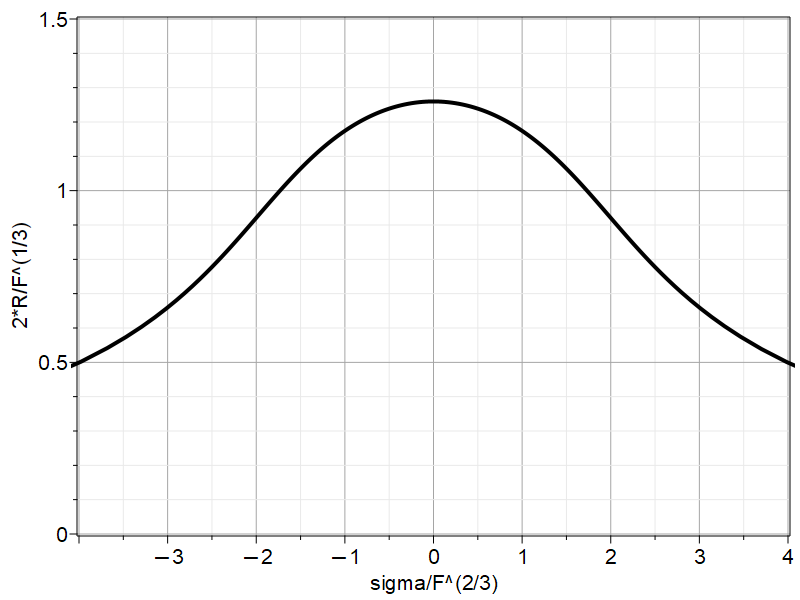

In [52]:
plot( [2^(2/3)*sin(p)/cos(p)^(1/3), 2^(1/3)*cos(p)^(1/3), p=-Pi/2..Pi/2],
view=[-4..4, 0..1.5],labels=[sigma/F^(2/3), 2*R/F^(1/3)], 
gridlines, thickness=4, labeldirections=[horizontal,vertical]);

In [53]:
FF1 := series( diff(R(tau),tau),e,3); # Eventually nonlinear in sin, cos

                        /

$$R \left(\tau \right) \left(-\frac{\sin \left(\theta \left(\tau \right)\right) F}{2 R \left(\tau \right)}-2 R \left(\tau \right)^{2}\right) \delta +R \left(\tau \right) \left(\frac{5 \cos \left(\theta \left(\tau \right)\right) F R \left(\tau \right)}{2}+\frac{3 \sigma  \sin \left(\theta \left(\tau \right)\right) F}{8 R \left(\tau \right)}+\sigma  R \left(\tau \right)^{2}\right) \delta^{2}+\mathrm{O}\left(\delta^{3}\right)$$

I thought we could simply solve these equations for sin and cos, and we can, but we have to do it perturbatively.  This takes more work, but it's not that bad.  I did it to $O(\delta^9)$ in a separate worksheet.

In [54]:
FF2 := series( diff(theta(tau),tau),e,3);

$$\frac{-32 \sigma  R \left(\tau \right)^{3}-32 F R \left(\tau \right)^{2} \cos \left(\theta \left(\tau \right)\right)}{64 R \left(\tau \right)^{3}} \delta +\frac{1}{64} \frac{24 F \cos \left(\theta \left(\tau \right)\right) R \left(\tau \right)^{2} \sigma +16 R \left(\tau \right)^{3} \sigma^{2}+64 R \left(\tau \right)^{7}+32 F \sin \left(\theta \left(\tau \right)\right) R \left(\tau \right)^{4}}{R \left(\tau \right)^{3}} \delta^{2}+\mathrm{O}\left(\delta^{3}\right)$$

In [55]:
sincos := solve( eval( [convert(FF1,polynom), convert(FF2,polynom)],
    [R(tau)=R,theta(tau)=theta,Phi=0]), [sin(theta),cos(theta)] );

$$\left[\left[\sin \left(\theta \right) = -\frac{16 R^{3} \left(10 R^{4} \delta^{2}+\delta^{2} \sigma^{2}-4\right)}{F \left(80 R^{4} \delta^{2}-9 \delta^{2} \sigma^{2}+24 \sigma  \delta -16\right)}, \cos \left(\theta \right) = -\frac{2 R \left(4 R^{4} \delta^{2} \sigma -16 R^{4} \delta -3 \delta^{2} \sigma^{3}+10 \delta  \,\sigma^{2}-8 \sigma \right)}{F \left(80 R^{4} \delta^{2}-9 \delta^{2} \sigma^{2}+24 \sigma  \delta -16\right)}\right]\right]$$

In [56]:
sine1 := series( eval( sin(theta), sincos[1]), e, 2 );

$$-\frac{4 R^{3}}{F}-6 \frac{R^{3} \sigma}{F} \delta +\mathrm{O}\left(\delta^{2}\right)$$

In [57]:
cose1 := series( eval( cos(theta), sincos[1]), e, 2 );

$$-\frac{\sigma  R}{F}+\left(\frac{R \left(-16 R^{4}+10 \sigma^{2}\right)}{8 F}-\frac{3 \sigma^{2} R}{2 F}\right) \delta +\mathrm{O}\left(\delta^{2}\right)$$

In [58]:
steady1 := series( sine1^2 + cose1^2 - 1, e, 2);

$$\frac{\sigma^{2} R^{2}}{F^{2}}+\frac{16 R^{6}}{F^{2}}-1+\left(-\frac{2 \sigma  R \left(\frac{R \left(-16 R^{4}+10 \sigma^{2}\right)}{8 F}-\frac{3 \sigma^{2} R}{2 F}\right)}{F}+\frac{48 R^{6} \sigma}{F^{2}}\right) \delta +\mathrm{O}\left(\delta^{2}\right)$$

In [59]:
map( simplify, steady1 );

$$\frac{\sigma^{2} R^{2}}{F^{2}}+\frac{16 R^{6}}{F^{2}}-1+\frac{1}{2} \frac{\sigma  \,R^{2} \left(104 R^{4}+\sigma^{2}\right)}{F^{2}} \delta +\mathrm{O}\left(\delta^{2}\right)$$

In [60]:
nice := convert( map(simplify,steady1), polynom)

$$\frac{\sigma^{2} R^{2}}{F^{2}}+\frac{16 R^{6}}{F^{2}}-1+\frac{\sigma  \,R^{2} \left(104 R^{4}+\sigma^{2}\right) \delta}{2 F^{2}}$$

In [61]:
simplify( eval( nice, [sigma=s*F^(2/3), R=rho*F^(1/3)/2]) );

$$-1+\frac{\delta  \left(13 \rho^{6} s +2 \rho^{2} s^{3}\right) F^{\frac{2}{3}}}{16}+\frac{\rho^{6}}{4}+\frac{\rho^{2} s^{2}}{4}$$

In [62]:
FFF := map( expand, Vector(2, eval( [convert(FF1,polynom)/e, 
                        convert(FF2,polynom)/e],
    [R(tau)=R,theta(tau)=theta,Phi=0]) ) ):

In [63]:
ressteady := map( expand, map(series,
  eval(FFF, [sin(theta)=sine1, cos(theta)=cose1]),
                 e, N+1 ) );

$$\left[\begin{array}{c}
\mathrm{O}\left(\delta^{2}\right) 
\\
 \mathrm{O}\left(\delta^{2}\right) 
\end{array}\right]$$

In [64]:
J2 := VectorCalculus:-Jacobian( FFF, [R, theta]):

In [65]:
J2 := eval( J2, [sin(theta)=sine1, cos(theta)=cose1]):

In [66]:
J2s := map(series, J2, e, N+1):

In [67]:
Je := map(m->collect(m,e,expand), map(convert, J2s, polynom) ):

In [68]:
tr := series( eval( LinearAlgebra:-Trace( Je ), [sin(theta)=sine1, cos(theta)=cose1] ), e, N+1 );

$$-8 R^{2}-4 \sigma  \,R^{2} \delta +\left(-10 R^{6}-\frac{5}{4} R^{2} \sigma^{2}\right) \delta^{2}$$

In [69]:
dt := series( eval( LinearAlgebra:-Determinant( Je ), [sin(theta)=sine1, cos(theta)=cose1] ), e, N+1 );

$$12 R^{4}+\frac{\sigma^{2}}{4}+\left(21 R^{4} \sigma -\frac{1}{4} \sigma^{3}\right) \delta +\left(9 R^{8}+4 R^{4} \sigma^{2}+\frac{1}{16} \sigma^{4}\right) \delta^{2}+\left(20 R^{8} \sigma +\frac{5}{2} R^{4} \sigma^{3}\right) \delta^{3}$$

For large enough $\sigma$, it is possible that the determinant could be negative or the trace could be positive (for $\sigma < -2/\delta)$.  But it would have to be $O(1/\delta)$, which voids the expansion in the first place.  So we conclude that, at higher orders, the steady state is again stable, and only $O(\delta)$ different to the steady states plotted above.

In [70]:
steadyR := map( simplify, series( sine1^2 + cose1^2, e, 2) );

$$\frac{R^{2} \left(16 R^{4}+\sigma^{2}\right)}{F^{2}}+\frac{1}{2} \frac{\sigma  \,R^{2} \left(104 R^{4}+\sigma^{2}\right)}{F^{2}} \delta +\mathrm{O}\left(\delta^{2}\right)$$

In [71]:
maybe := eval(steadyR, [R=rho/2*F^(1/3), sigma=s*F]);

$$\frac{\rho^{2} \left(\rho^{4} F^{\frac{4}{3}}+s^{2} F^{2}\right)}{4 F^{\frac{4}{3}}}+\frac{1}{8} \frac{s \,\rho^{2} \left(\frac{13 \rho^{4} F^{\frac{4}{3}}}{2}+s^{2} F^{2}\right)}{F^{\frac{1}{3}}} \delta +\mathrm{O}\left(\delta^{2}\right)$$

In [72]:
maybe := convert(maybe,polynom);

$$\frac{\rho^{2} \left(\rho^{4} F^{\frac{4}{3}}+s^{2} F^{2}\right)}{4 F^{\frac{4}{3}}}+\frac{s \,\rho^{2} \left(\frac{13 \rho^{4} F^{\frac{4}{3}}}{2}+s^{2} F^{2}\right) \delta}{8 F^{\frac{1}{3}}}$$

In [73]:
collect( maybe/rho^2, delta, factor);

$$\frac{s \left(13 \rho^{4} F^{\frac{4}{3}}+2 s^{2} F^{2}\right) \delta}{16 F^{\frac{1}{3}}}+\frac{\rho^{4} F^{\frac{4}{3}}+s^{2} F^{2}}{4 F^{\frac{4}{3}}}$$

In [74]:
8031./3600

$$ 2.230833333$$

In [75]:
latex( series( collect(ztrig,e,m->nops(m)), e, N+1 ));

3+3 \delta +3 \delta^{2}+8 \delta^{3}

In [76]:
highview := map(LargeExpressions:-Veil[K], combine( expand(coeff(ztrig,delta,N)),trig), [R(tau)=R] )   ;

$$\frac{3 K_{4}}{32}+\frac{7 K_{5}}{64}+\frac{37 K_{6}}{12}-\frac{K_{7}}{9}+\frac{17 K_{8}}{12}-\frac{25 K_{9}}{16}+\frac{5 K_{10}}{36}-\frac{K_{11}}{4}$$

In [77]:
max( map( length, ( PolynomialTools:-CoefficientList( highview, indets(highview) ) ) ) );

$$7$$

In [78]:
F10 := 10;
delta10 := 0.1; #0.20625; # .15 is slightly too big; 0.1 gives residual 0.05; this gives 2!
sigma10 := 0;

                                delta10 := 0.1

$$0$$

In [79]:
zsample := eval(ztrig, [F=F10, delta=delta10, sigma=sigma10]):

In [80]:
des := {diff(RR(tau),tau)=
 eval(diff(R(tau),tau), [R(tau)=RR(tau), theta(tau)=THETA(tau)]),
 diff(THETA(tau),tau) = eval( diff(theta(tau),tau), 
 [R(tau)=RR(tau), theta(tau)=THETA(tau)])}:

In [81]:
desample := eval( des,[F=F10, delta=delta10,sigma=sigma10] ):

In [82]:
sol := dsolve( desample union {RR(0)=0.1, THETA(0)=0.0}, {RR(tau),THETA(tau)}, numeric):

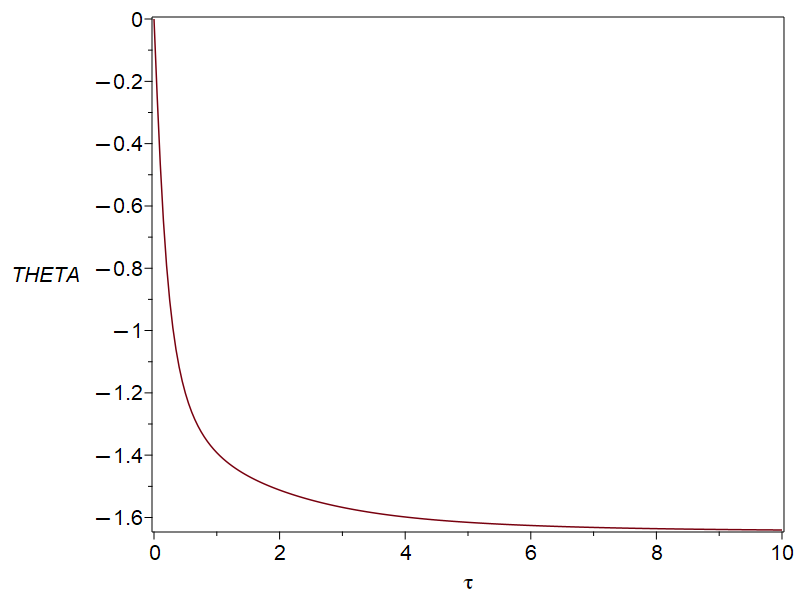

In [83]:
plots[odeplot]( sol, [tau,THETA(tau)], tau=0..10);

In [84]:
evalf(delta10^(N+1));

$$ 0.0001$$

In [85]:
t10 := eval( sol(10.0), [RR=R,THETA=theta] )[2..3];

$$[R \left(\tau \right) =  1.38310428707153465, \theta \left(\tau \right) = - 1.64016986416441646]$$

In [86]:
zs := eval(ztrig, [op(t10), F=F10, delta=delta10, sigma=sigma10]):

In [87]:
fr := eval( eval(WeaklyNonlinear, u(tau)=ztrig),  
  [op(t10), F=F10, delta=delta10, sigma=sigma10] ):

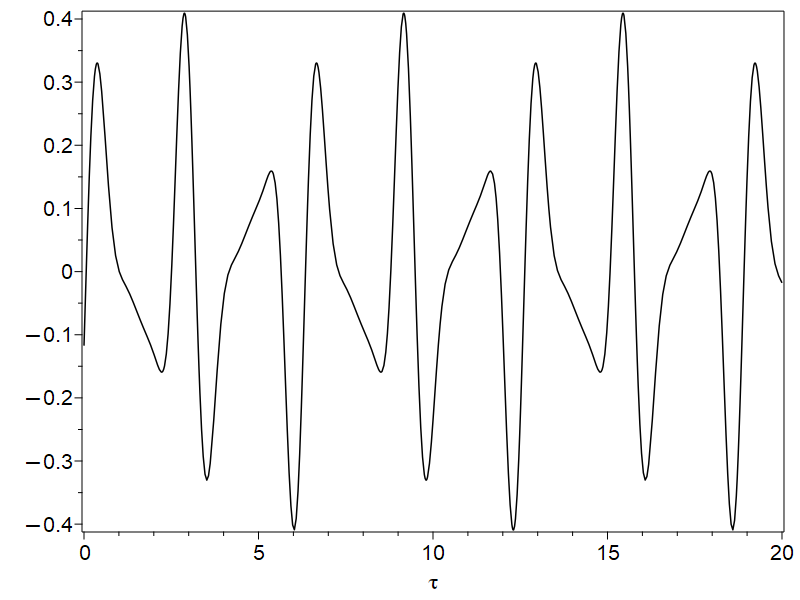

In [88]:
plot( fr, tau=0..20); # This residual is O(1) and thus too big.

In [89]:
datapts := [
seq(
eval( [zs/delta10, diff(zs,tau)/delta10], tau=k ), 
k=0..1000)]:

kilobytes used=114881, alloc=23608, time=9.19

In [90]:
datapts[1];

$$[- 1.28828140784163714,  25.7549825757673609]$$

        AXESLABELS("", "", FONT("Arial", 16)))

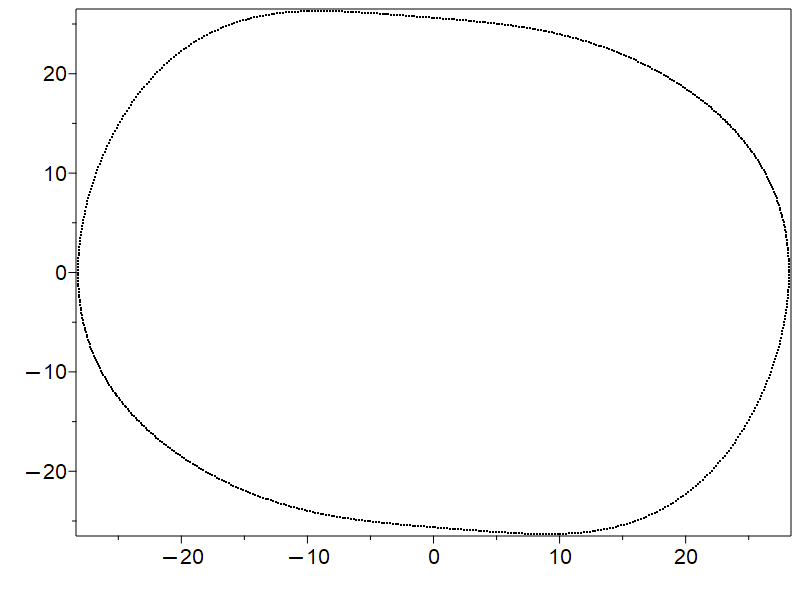

In [91]:
pertplot := plots[pointplot]( datapts, symbol=point); # Visibly departs

In [92]:
wample := evalc( eval( WeaklyNonlineart, [F=F10,delta=delta10,sigma=sigma10] ) );

$$\frac{d^{2}}{d t^{2}}y \left(t \right)- 0.001 \left(\frac{d}{d t}y \left(t \right)\right) \left(1-\frac{4 \left(\frac{d}{d t}y \left(t \right)\right)^{2}}{3}\right)+y \left(t \right)-20 \cos \left( 1.0 t \right)$$

In [93]:
tsol := dsolve( {wample, y(0)=0.1, D(y)(0)=0.0}, y(t), numeric,maxfun=10^7 ):

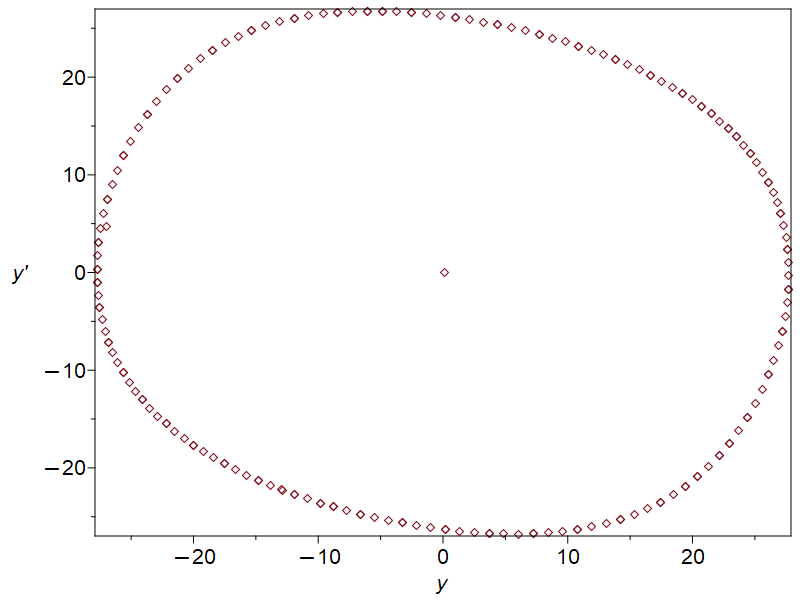

In [94]:
numplot := plots[odeplot]( tsol, [y(t),diff(y(t),t)], t=0..1000, style=point);

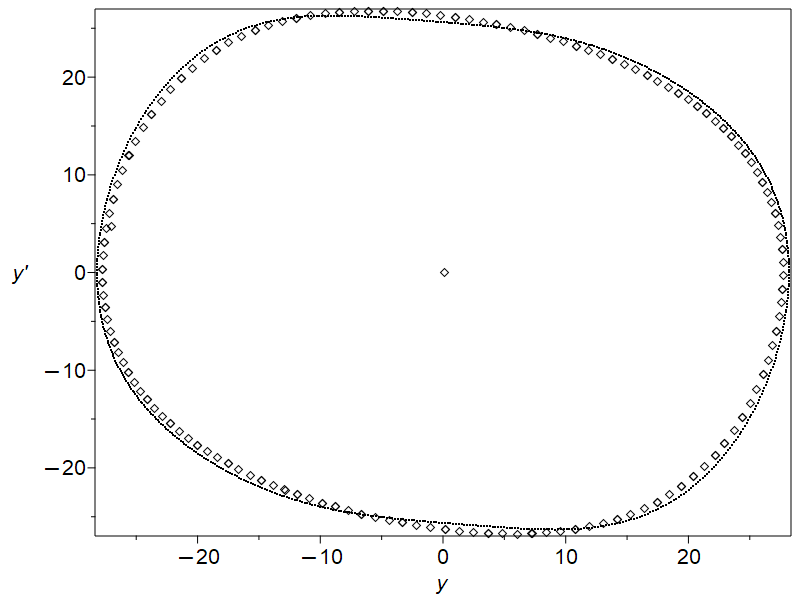

In [95]:
plots[display]( pertplot, numplot ); # The two solutions compared